Task:
Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.


In [3]:
# Importing all the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets




In [4]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv(r"C:\Users\santh\Downloads\Datasets\E-commerce.csv",encoding="ISO-8859-1")

# generating one row
df = data.sample(frac =.10)


In [5]:
df.count()

InvoiceNo      54191
StockCode      54191
Description    54048
Quantity       54191
InvoiceDate    54191
UnitPrice      54191
CustomerID     40671
Country        54191
dtype: int64

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,54191.000000,54191.000000,40671.000000
mean,7.905150,4.889297,15291.844140
std,325.633029,120.463611,1714.591628
min,-74215.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13974.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16802.000000
max,4800.000000,16453.710000,18287.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54191 entries, 255893 to 519144
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54191 non-null  object 
 1   StockCode    54191 non-null  object 
 2   Description  54048 non-null  object 
 3   Quantity     54191 non-null  int64  
 4   InvoiceDate  54191 non-null  object 
 5   UnitPrice    54191 non-null  float64
 6   CustomerID   40671 non-null  float64
 7   Country      54191 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.7+ MB


In [8]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      143
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13520
Country            0
dtype: int64

In [9]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Week']=df.InvoiceDate.dt.isocalendar().week
df['Year_Month']=df.InvoiceDate.dt.to_period('M')
df['Hour']=df.InvoiceDate.dt.hour
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
df['weekday'] = df.InvoiceDate.dt.day_name()
df['Quarter'] = df.Month.apply(lambda m:'Q'+str(ceil(m/4)))
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Month,Week,Year_Month,Hour,Day,is_cancelled,weekday,Quarter,Date
255893,559372,48187,DOORMAT NEW ENGLAND,6,2011-07-08 10:23:00,7.95,12461.0,Switzerland,47.70,2011,7,27,2011-07,10,8,No,Friday,Q2,2011-07-08
232822,557330,22025,RING OF ROSES BIRTHDAY CARD,12,2011-06-20 10:20:00,0.42,14291.0,United Kingdom,5.04,2011,6,25,2011-06,10,20,No,Monday,Q2,2011-06-20
216710,555852,21907,I'M ON HOLIDAY METAL SIGN,12,2011-06-07 13:38:00,2.10,17429.0,United Kingdom,25.20,2011,6,23,2011-06,13,7,No,Tuesday,Q2,2011-06-07
352912,567700,20728,LUNCH BAG CARS BLUE,10,2011-09-22 09:33:00,1.65,16379.0,United Kingdom,16.50,2011,9,38,2011-09,9,22,No,Thursday,Q3,2011-09-22
298117,562980,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-08-11 11:44:00,1.65,17686.0,United Kingdom,16.50,2011,8,32,2011-08,11,11,No,Thursday,Q2,2011-08-11


CustomerID and Description is missing.Since it represents 25% of the data This would affect in finding Potential customers

<BarContainer object of 2 artists>

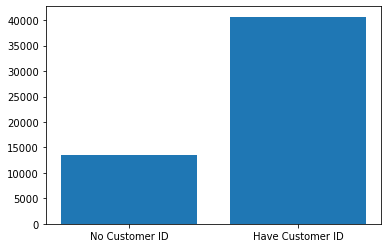

In [10]:
import matplotlib.pyplot as plt

no_customer_id = len(df[df['CustomerID'].isnull()].index)
have_customer_id = len(df[~df['CustomerID'].isnull()].index)

plt.bar(['No Customer ID','Have Customer ID'],[no_customer_id, have_customer_id])


In [11]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df.UnitPrice),row=1, col=1)
fig.add_trace(go.Box(y=df.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=df.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

In [12]:
df_=df[df.is_cancelled=='No']
del df

In [13]:
sales_by_date = df_.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

In [14]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

In [15]:
customer_by_month1 = df_.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = df_.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

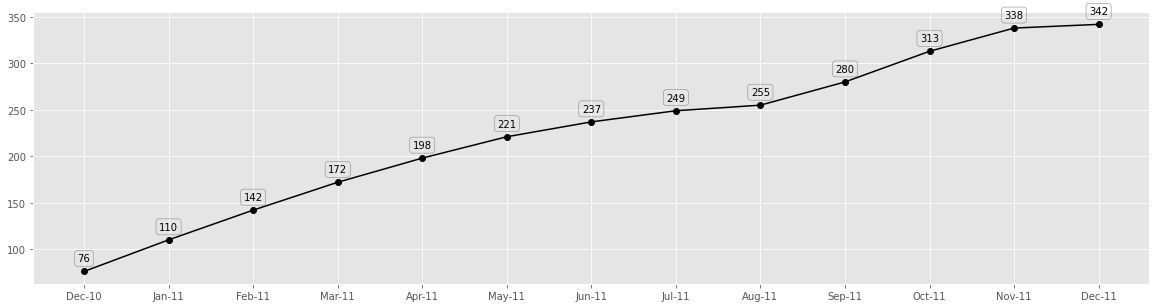

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month


Customer acquisition VS Sales contribution

In [17]:
customer_sales = df_.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

Frequent purchasing:
Most of customers made their next purchase after one or two months of first purchase.
There were 28 customers who made their first purchase in Dec 2010 also made their next purchase after 12 months.33 customers made their second purchase after 7 months of their first purchase in Mar 2011.

Hourly sales

In [20]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]